In [ ]:
from google.colab import drive
drive.mount('/content/drive2')

Mounted at /content/drive2


In [ ]:
drive_wsi_path='/content/drive2/MyDrive/CAMELYON17'

# Setup

In [ ]:
!sudo apt install openslide-tools --quiet 
!pip install openslide-python --quiet 
!pip install rasterio --quiet

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (1,086 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This fro

In [ ]:
import glob
import os
import shutil
import numpy as np
import zipfile
import openslide
import h5py
import matplotlib.pyplot as plt
import cv2, tqdm
import rasterio.features
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from shapely.geometry import Polygon
from shapely.geometry import LineString, MultiPolygon, Polygon, Point
from shapely.ops import polygonize

from sklearn.cluster import KMeans
from skimage.draw import polygon2mask, polygon, polygon_perimeter

from pathlib import Path

from google.colab.patches import cv2_imshow

In [ ]:
!git clone https://github.com/mahmoodlab/CLAM.git

Cloning into 'CLAM'...
remote: Enumerating objects: 565, done.
remote: Counting objects: 100% (243/243), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 565 (delta 180), reused 168 (delta 168), pack-reused 322
Receiving objects: 100% (565/565), 46.80 MiB | 28.94 MiB/s, done.
Resolving deltas: 100% (288/288), done.


# Extract and Copy data

In [ ]:
def Extract_Data(path_data, destination, patient_id = None, node_id = None):
   
  paths_data=glob.glob(path_data)

  if(patient_id != None):
    paths_data = [patient_path for patient_path in paths_data if patient_id in patient_path]
    
  for data_file in paths_data:
    if(os.path.exists(data_file)):
      Extract_Data_Patient(data_file,destination,node_id)
    else:
      return False

  return True

In [ ]:
def Extract_Data_Patient(data_file, destination, node_id = None):# copy a zip from camelyon training

  print("\nExtracting ", data_file)
  patient = data_file.split('/')[-1][:-4]
  destination = destination+patient+'/' 

  with zipfile.ZipFile(data_file, 'r') as zip_ref:
    namelist = zip_ref.namelist()
      
    if (node_id == None):
      print('Inflating:')
      for name in namelist:
        print(name)

      zip_ref.extractall(destination)
  
    else:
      print('Inflating: ')
      for nodefile in namelist:
        if node_id in nodefile:
           print(nodefile)
           zip_ref.extract(nodefile, destination )
     

  

In [ ]:
"""!mkdir data
!ls /content/training_data/patient_009/ | grep 1.tif | xargs -I aa cp aa data"""

'!mkdir data\n!ls /content/training_data/patient_009/ | grep 1.tif | xargs -I aa cp aa data'

# Create Patches

In [ ]:
def patchify_CLAM(patient_id):
  path = 'training_data/' + patient_id + '/'
  !python CLAM/create_patches.py --source {path} --save_dir RESULTS_DIRECTORY --patch_size 512 --step_size 512 --patch_level 1 --seg --patch --stitch 

In [ ]:
"""save_dir = 'RESULTS_DIRECTORY'
source = 'training_data/' + patient_id#patient_009'

patch_size = 512
step_size = 256
seg = True
stitch = True
patch = True
custom_downsample=1
patch_level=0
process_list = None
no_auto_skip = True"""

"save_dir = 'RESULTS_DIRECTORY'\nsource = 'training_data/' + patient_id#patient_009'\n\npatch_size = 512\nstep_size = 256\nseg = True\nstitch = True\npatch = True\ncustom_downsample=1\npatch_level=0\nprocess_list = None\nno_auto_skip = True"

In [ ]:
"""patch_save_dir = os.path.join(save_dir, 'patches')
mask_save_dir = os.path.join(save_dir, 'masks')
stitch_save_dir = os.path.join(save_dir, 'stitches')

process_list = None

print('source: ', source)
print('patch_save_dir: ', patch_save_dir)
print('mask_save_dir: ', mask_save_dir)
print('stitch_save_dir: ', stitch_save_dir)

directories = {'source': source, 
          'save_dir': save_dir,
          'patch_save_dir': patch_save_dir, 
          'mask_save_dir' : mask_save_dir, 
          'stitch_save_dir': stitch_save_dir} 

for key, val in directories.items():
  print("{} : {}".format(key, val))
  if key not in ['source']:
    os.makedirs(val, exist_ok=True)


seg_params = {'seg_level': -1, 'sthresh': 8, 'mthresh': 7, 'close': 4, 'use_otsu': False,
        'keep_ids': 'none', 'exclude_ids': 'none'}
filter_params = {'a_t':100, 'a_h': 16, 'max_n_holes':8 }
vis_params = {'vis_level': -1, 'line_thickness': 250}
patch_params = {'white_thresh': 5, 'black_thresh': 40, 'use_padding': True, 'contour_fn': 'four_pt'}

parameters = {'seg_params': seg_params,
        'filter_params': filter_params,
        'patch_params': patch_params,
        'vis_params': vis_params}

print(parameters)


seg_times, patch_times = create_patches.seg_and_patch(**directories, **parameters,
                    patch_size = patch_size, step_size=step_size, 
                    seg = seg,  use_default_params=False, save_mask = True, 
                    stitch= stitch, custom_downsample = custom_downsample, 
                    patch_level=patch_level, patch = patch,
                    process_list = process_list, auto_skip=no_auto_skip)"""

'patch_save_dir = os.path.join(save_dir, \'patches\')\nmask_save_dir = os.path.join(save_dir, \'masks\')\nstitch_save_dir = os.path.join(save_dir, \'stitches\')\n\nprocess_list = None\n\nprint(\'source: \', source)\nprint(\'patch_save_dir: \', patch_save_dir)\nprint(\'mask_save_dir: \', mask_save_dir)\nprint(\'stitch_save_dir: \', stitch_save_dir)\n\ndirectories = {\'source\': source, \n          \'save_dir\': save_dir,\n          \'patch_save_dir\': patch_save_dir, \n          \'mask_save_dir\' : mask_save_dir, \n          \'stitch_save_dir\': stitch_save_dir} \n\nfor key, val in directories.items():\n  print("{} : {}".format(key, val))\n  if key not in [\'source\']:\n    os.makedirs(val, exist_ok=True)\n\n\nseg_params = {\'seg_level\': -1, \'sthresh\': 8, \'mthresh\': 7, \'close\': 4, \'use_otsu\': False,\n        \'keep_ids\': \'none\', \'exclude_ids\': \'none\'}\nfilter_params = {\'a_t\':100, \'a_h\': 16, \'max_n_holes\':8 }\nvis_params = {\'vis_level\': -1, \'line_thickness\': 250

In [ ]:
#!rm /content/RESULTS_DIRECTORY/ -r

In [ ]:
#!du -h /content/RESULTS_DIRECTORY/patches/patient_009_node_1.h5

In [ ]:
# copy back to drive
#!cp /content/RESULTS_DIRECTORY/patches/patient_009_node_0.h5 '/content/drive2/MyDrive/fyp-h5/'

#Reading H5


In [ ]:
def getPatchCoords(file_path):

  with h5py.File(file_path, 'r') as f:
      print(f.keys())
      keys=list(f.keys())

      patches = list(f[keys[0]]) 

      print("Keyed (", len(patches),") patches")
      return patches


# Read annotations

In [ ]:
!mkdir /content/training_annotations
!unzip '/content/drive2/MyDrive/CAMELYON17/training/lesion_annotations.zip' -d /content/training_annotations

Archive:  /content/drive2/MyDrive/CAMELYON17/training/lesion_annotations.zip
  inflating: /content/training_annotations/patient_004_node_4.xml  
  inflating: /content/training_annotations/patient_009_node_1.xml  
  inflating: /content/training_annotations/patient_010_node_4.xml  
  inflating: /content/training_annotations/patient_012_node_0.xml  
  inflating: /content/training_annotations/patient_015_node_1.xml  
  inflating: /content/training_annotations/patient_015_node_2.xml  
  inflating: /content/training_annotations/patient_016_node_1.xml  
  inflating: /content/training_annotations/patient_017_node_1.xml  
  inflating: /content/training_annotations/patient_017_node_2.xml  
  inflating: /content/training_annotations/patient_017_node_4.xml  
  inflating: /content/training_annotations/patient_020_node_2.xml  
  inflating: /content/training_annotations/patient_020_node_4.xml  
  inflating: /content/training_annotations/patient_021_node_3.xml  
  inflating: /content/training_annotati

In [ ]:
def read_annotations(src):
  tree = ET.parse(src)
  polygon_points = []
  for child1 in tree.getroot():
    for child2 in child1:
        for child3 in child2:
            pp = []
            for child in child3:
                pp.append([float(child.attrib['X']), float(child.attrib['Y'])])
                #print(child.attrib['X'])
            if(len(pp) > 0):
              if(len(pp) > 3):
                #difference = 3 - len(pp)
                #for j in range(difference):
                  #pp.append(pp[j])
                
                polygon_points.append(np.array(pp))


  mxx = polygon_points[0][:,0].max()
  mnx = polygon_points[0][:,0].min()
  mxy = polygon_points[0][:,1].max()
  mny = polygon_points[0][:,1].min()
  for i in range(1,len(polygon_points)):
    mxx = max(mxx, polygon_points[i][:,0].max())
    mnx = min(mnx, polygon_points[i][:,0].min())
    mxy = max(mxy, polygon_points[i][:,1].max())
    mny = min(mny, polygon_points[i][:,1].min())

  #for i in range(len(polygon_points) - 1):
  #  polygon_points[i][:,0] = (polygon_points[i][:,0] - mnx)
  #  polygon_points[i][:,1] = (polygon_points[i][:,1] - mny)
  
  return polygon_points, [mxx,mnx], [mxy,mny]
#polygon_points = np.array(polygon_points)
# https://shapely.readthedocs.io/en/stable/manual.html
# take intersection with patch shape and annotation shape to get annotation that is in the patch

#Masking

In [ ]:
def getpolygonfrompatch(patch_coord, patch_size):
  x,y = patch_coord
  mask = Polygon([(x,y), (x+patch_size,y), (x+patch_size,y+patch_size), (x,y+patch_size)])
  return mask

In [ ]:
def calculate_intersection(patch_coord, ann_coords):
  mask = getpolygonfrompatch(patch_coord, 512)
  polyg = Polygon(ann_coords)

  intersection = polyg.intersection(mask)
  return intersection

In [ ]:
#Accessory function, not currently working, not used
def flatten_polygon(poly):
  if len(poly) == 'Polygon':
    return poly
  elif poly.geoms.type == 'MultiPolygon':
    allparts = [p.buffer(0) for p in poly.geoms[0]]
    poly.geoms = shapely.ops.cascaded_union(allparts)
    return poly

In [ ]:
def createMasksforNode(patches, src_annotation, mask_level):
  ppoints, [mxx,mnx], [mxy, mny] = read_annotations(src_annotation)
  print("Max X - min X to get reduced dimensions:", mxx-mnx)

  #print("ppoints before:", ppoints[0])

  if(mask_level > 0):
    for i in range(len(ppoints)):
      ppoints[i] = ppoints[i]/(2**mask_level)

  #print("ppoints after downsapling, ",ppoints[0])
  ginter = 0
  hitcounter = 0
  p_hitcounter = 0
  maskpolygons = []

  patch_num = 0
  for p in patches:

    if(patch_num %1000 == 0):
      print("Processing patch: ", patch_num)

    patch_num += 1
    p_inter = Polygon()
    for ann_coords in ppoints:
      
      try:
        inter = calculate_intersection(p,ann_coords)
        
        if(inter.area > 0.0):
       
          p_inter = p_inter.union(inter)
          #x,y = inter.exterior.xy
          #imgintr = polygon2mask((512,512),[[x1 - min(x),y1-min(y)] for x1,y1 in zip(x,y)]).astype(int)
          #cv2.im
          hitcounter = hitcounter+1

      except:
        print("Invalid intersection of patch and ann:", p, ann_coords)

      
        
        #ginter = inter
    if(p_inter.area > 0.0):
      p_hitcounter += 1
      #print("Patch Hit: ", p)
      maskpolygons.append([p,p_inter])

  print("Number of Patch - Annotation hits:",  hitcounter)
  print("Number of Patch hits:",  p_hitcounter)

  if(hitcounter < 0):
    print("No Hits")
    return None
  else:
    return maskpolygons

    



In [ ]:
def WriteMasks(masks, src):
  
  p_id = str(src).split('/')[-1]
  p_num = p_id[:11] 
  node_num = p_id[12:-4]
  os.makedirs('/content/masks/' + p_num + '/' + node_num + '/')


  type_polygon = type(Polygon())
  type_multipolygon = type(MultiPolygon())

  for m in tqdm.tqdm(masks):

    patch_coords = m[0]  
    type_geom =  type(m[1])

    if(type_geom == type_multipolygon):
      imgintr = np.zeros((512,512))
       
      for geom in m[1].geoms:
        x,y = geom.exterior.xy
       
        #if(imgintr_b == False ):
        #  imgintr_b = True
        #  imgintr = polygon2mask((512,512),[[x1 - min(x),y1-min(y)] for x1,y1 in zip(x,y)]).astype(int)
        #else:
        imgintr += polygon2mask((512,512),[[x1 - patch_coords[0],y1-patch_coords[1]] for x1,y1 in zip(x,y)]).astype(int)
      
      imgintr = imgintr*255
      
 

    elif(type_geom == type_polygon):
      x,y = m[1].exterior.xy
      imgintr = polygon2mask((512,512),[[x1 - patch_coords[0],y1-patch_coords[1]] for x1,y1 in zip(x,y)]).astype(int)
      imgintr = imgintr*255
    
    else:
      continue

    name = f"mp_{m[0][0]}_{m[0][1]}.png"
    cv2.imwrite('/content/masks/' + p_num + '/' + node_num + '/'+name,np.fliplr(np.rot90(imgintr, -1)))

In [ ]:
#!rm /content/masks/ -r

In [ ]:
#!zip -r "/content/masks.zip" "/content/masks/"

In [ ]:
#!cp /content/masks.zip /content/drive2/MyDrive/fyp/

In [ ]:
#!du -h "/content/masks/"

#Tiling WSI

In [ ]:
def CreateTilingDirectory(src, target):
  h5_files = glob.glob(src+'*')
  path_tiling = h5_files.copy()
  for i in range(len(path_tiling)):
    p_id = str(path_tiling[i]).split('/')[-1]
    path_tiling[i] = target + p_id[:11] + "/" + p_id[12:-3]

  [os.makedirs(path_tile) for path_tile in path_tiling]

  return h5_files

In [ ]:
def TileWSI(f, target, patient_id, node_id):
  p_id = str(f).split('/')[-1]
  p_num = p_id[:11] 
  node_num = p_id[12:-3]

  patches = getPatchCoords(f)

  print("\Processing ", f)
  print("Total Number of Patches:", len(patches))
  
  count = 0
  slide = openslide.OpenSlide('/content/training_data/' + patient_id + '/' + patient_id
                          + '_' + node_id + '.tif')# patient_009/patient_009_node_1.tif')
  for p in tqdm.tqdm(patches):
    #print("\rProcessed ", count, " patches", end='')
    #count += 1

    name = f"p_{p[0]}_{p[1]}.png"
    slide.read_region(tuple(p*2),1,(512,512)).save(target + p_num + "/" + node_num + "/" + name)
    #cv2.imwrite(target + p_num + "/" + node_num + "/" + name, slide.read_region(tuple(p*2),1,(512,512)))

In [ ]:
def TileAllWSI(src, target, pid, nid):

  h5_files = CreateTilingDirectory(src, target)

  for f in h5_files:
    TileWSI(f, target, pid, nid)
    


In [ ]:
#!rm /content/Tiles -r

In [ ]:
!du -h "/content/Tiles/"

du: cannot access '/content/Tiles/': No such file or directory


#Prepare, Mask and Tile

In [ ]:
def Prepare_ZipData(patient_data):
  
  zip_path='training'
  path_training_data=os.path.join(drive_wsi_path, zip_path,"*","*.zip")
  print(path_training_data)
  #patient_id = 'patient_009'
  #node_id = 'node_1'

  print("\n[+] Extracting Data from path: ", path_training_data )

  for i in range(len(patient_data)):
    patient = patient_data[i]
    #print(patient)

    patient_id = patient[0]
    node_id = patient[1]

    #Extract Patient Data from Camelyon zip to .tif folders
    if not (os.path.exists('/content/training_data/'+patient_id+'/')):
      e = Extract_Data(path_training_data, '/content/training_data/', patient_id, node_id)

In [ ]:
def Mask_and_Tile(patching=True):

  #!python CLAM/create_patches.py --source training_data/*/* --save_dir RESULTS_DIRECTORY --patch_size 512 --step_size 512 --patch_level 1 --seg --patch --stitch 

  #using i in rnage instead of patient in patient data because of in order retireval
  patient_data = glob.glob('/content/training_data/*/*')
  for i in range(len(patient_data)):
    patient_data[i] = patient_data[i].split("/")[-1][:-4].split("_n")
    patient_data[i][1] = "n"+patient_data[i][1]


  for i in range(len(patient_data)):


    patient = patient_data[i]
    patient_id = patient[0]
    node_id = patient[1]


    polygon_points, mx, my = read_annotations('/content/training_annotations/' + patient_id
                          + '_' + node_id + '.xml')#patient_009_node_1.xml')

    fig, ax = plt.subplots()

    for poly in polygon_points:
      x, y = Polygon(poly).exterior.xy
      ax.plot(x,y)

    print("\n----------------------------------------------")
    print("\n[+] Processing file: ", patient_id, "_", node_id)

    

    if not (os.path.exists("/content/RESULTS_DIRECTORY/patches/" +patient_id+ "_" + node_id + ".h5")):
      print("\n[+] Creating Patches for training Data using CLAM")
      patchify_CLAM(patient_id)

   
    print("\n[-] Reading Patch Coordinates from h5")
    patches = getPatchCoords("/content/RESULTS_DIRECTORY/patches/" + patient_id
                            + '_' + node_id + '.h5')#patient_009_node_1.h5")

    
    if not (os.path.exists("/content/masks/" + patient_id + "/" + node_id + "/")):
      print("\n[-] Writing Masks")
      src_annotation = '/content/training_annotations/' + patient_id + '_' + node_id + '.xml' #patient_009_node_1.xml'
      WriteMasks(createMasksforNode(patches,src_annotation, 1), src_annotation)

    if not (os.path.exists("/content/Tiles/" + patient_id + "/" + node_id + "/")) and patching==True:
      print("\n[-] Creating and writing Tiles")
      os.makedirs("/content/Tiles/" + patient_id + "/" + node_id + "/")
      TileWSI('/content/RESULTS_DIRECTORY/patches/'+patient_id+'_'+node_id+'.h5', '/content/Tiles/', patient_id, node_id)


#RUN

In [ ]:
!rm /content/training_data -r
!mkdir training_data

rm: cannot remove '/content/training_data': No such file or directory


In [ ]:
patient_data = glob.glob('/content/training_annotations/*')
p_data = []
for i in range(len(patient_data)):
  patient_data[i] = patient_data[i].split("/")[-1][:-4].split("_n")
  patient_data[i][1] = "n"+patient_data[i][1]
  if not (os.path.exists('/content/drive2/MyDrive/fyp/masks/'+ patient_data[i][0] + '/' + patient_data[i][1])):
    p_data.append(patient_data[i])
patient_data = p_data


In [ ]:
Prepare_ZipData(patient_data[0:5])

/content/drive2/MyDrive/CAMELYON17/training/*/*.zip

[+] Extracting Data from path:  /content/drive2/MyDrive/CAMELYON17/training/*/*.zip

Extracting  /content/drive2/MyDrive/CAMELYON17/training/center_2/patient_044.zip
Inflating: 
patient_044_node_4.tif

Extracting  /content/drive2/MyDrive/CAMELYON17/training/center_3/patient_061.zip
Inflating: 
patient_061_node_4.tif

Extracting  /content/drive2/MyDrive/CAMELYON17/training/center_0/patient_016.zip
Inflating: 
patient_016_node_1.tif


In [ ]:
!rm /content/masks -r
!rm /content/Tiles -r
!rm /content/RESULTS_DIRECTORY -r


----------------------------------------------

[+] Processing file:  patient_081 _ node_4

[+] Creating Patches for training Data using CLAM
source:  training_data/patient_081/
patch_save_dir:  RESULTS_DIRECTORY/patches
mask_save_dir:  RESULTS_DIRECTORY/masks
stitch_save_dir:  RESULTS_DIRECTORY/stitches
source : training_data/patient_081/
save_dir : RESULTS_DIRECTORY
patch_save_dir : RESULTS_DIRECTORY/patches
mask_save_dir : RESULTS_DIRECTORY/masks
stitch_save_dir : RESULTS_DIRECTORY/stitches
{'seg_params': {'seg_level': -1, 'sthresh': 8, 'mthresh': 7, 'close': 4, 'use_otsu': False, 'keep_ids': 'none', 'exclude_ids': 'none'}, 'filter_params': {'a_t': 100, 'a_h': 16, 'max_n_holes': 8}, 'patch_params': {'white_thresh': 5, 'black_thresh': 40, 'use_padding': True, 'contour_fn': 'four_pt'}, 'vis_params': {'vis_level': -1, 'line_thickness': 250}}


progress: 0.00, 0/1
processing patient_081_node_4.tif
Creating patches for:  patient_081_node_4 ...
Bounding Box: 7808 6400 48257 66433
Contour

100%|██████████| 10/10 [00:00<00:00, 27.79it/s]



[-] Creating and writing Tiles
<KeysViewHDF5 ['coords', 'imgs']>
Keyed ( 3997 ) patches
\Processing  /content/RESULTS_DIRECTORY/patches/patient_081_node_4.h5
Total Number of Patches: 3997


100%|██████████| 3997/3997 [08:05<00:00,  8.24it/s]



----------------------------------------------

[+] Processing file:  patient_036 _ node_3

[+] Creating Patches for training Data using CLAM
source:  training_data/patient_036/
patch_save_dir:  RESULTS_DIRECTORY/patches
mask_save_dir:  RESULTS_DIRECTORY/masks
stitch_save_dir:  RESULTS_DIRECTORY/stitches
source : training_data/patient_036/
save_dir : RESULTS_DIRECTORY
patch_save_dir : RESULTS_DIRECTORY/patches
mask_save_dir : RESULTS_DIRECTORY/masks
stitch_save_dir : RESULTS_DIRECTORY/stitches
{'seg_params': {'seg_level': -1, 'sthresh': 8, 'mthresh': 7, 'close': 4, 'use_otsu': False, 'keep_ids': 'none', 'exclude_ids': 'none'}, 'filter_params': {'a_t': 100, 'a_h': 16, 'max_n_holes': 8}, 'patch_params': {'white_thresh': 5, 'black_thresh': 40, 'use_padding': True, 'contour_fn': 'four_pt'}, 'vis_params': {'vis_level': -1, 'line_thickness': 250}}


progress: 0.00, 0/1
processing patient_036_node_3.tif
Creating patches for:  patient_036_node_3 ...
Bounding Box: 15427 160078 39531 31780
Cont

100%|██████████| 31/31 [00:00<00:00, 35.22it/s]



[-] Creating and writing Tiles
<KeysViewHDF5 ['coords', 'imgs']>
Keyed ( 3781 ) patches
\Processing  /content/RESULTS_DIRECTORY/patches/patient_036_node_3.h5
Total Number of Patches: 3781


100%|██████████| 3781/3781 [10:59<00:00,  5.73it/s]



----------------------------------------------

[+] Processing file:  patient_086 _ node_4

[+] Creating Patches for training Data using CLAM
source:  training_data/patient_086/
patch_save_dir:  RESULTS_DIRECTORY/patches
mask_save_dir:  RESULTS_DIRECTORY/masks
stitch_save_dir:  RESULTS_DIRECTORY/stitches
source : training_data/patient_086/
save_dir : RESULTS_DIRECTORY
patch_save_dir : RESULTS_DIRECTORY/patches
mask_save_dir : RESULTS_DIRECTORY/masks
stitch_save_dir : RESULTS_DIRECTORY/stitches
{'seg_params': {'seg_level': -1, 'sthresh': 8, 'mthresh': 7, 'close': 4, 'use_otsu': False, 'keep_ids': 'none', 'exclude_ids': 'none'}, 'filter_params': {'a_t': 100, 'a_h': 16, 'max_n_holes': 8}, 'patch_params': {'white_thresh': 5, 'black_thresh': 40, 'use_padding': True, 'contour_fn': 'four_pt'}, 'vis_params': {'vis_level': -1, 'line_thickness': 250}}


progress: 0.00, 0/1
processing patient_086_node_4.tif
Creating patches for:  patient_086_node_4 ...
Bounding Box: 48704 59584 31873 31553
Conto

100%|██████████| 2/2 [00:00<00:00, 104.60it/s]


[-] Creating and writing Tiles
<KeysViewHDF5 ['coords', 'imgs']>


Keyed ( 3458 ) patches
\Processing  /content/RESULTS_DIRECTORY/patches/patient_086_node_4.h5
Total Number of Patches: 3458


100%|██████████| 3458/3458 [06:34<00:00,  8.76it/s]



----------------------------------------------

[+] Processing file:  patient_024 _ node_1

[+] Creating Patches for training Data using CLAM
source:  training_data/patient_024/
patch_save_dir:  RESULTS_DIRECTORY/patches
mask_save_dir:  RESULTS_DIRECTORY/masks
stitch_save_dir:  RESULTS_DIRECTORY/stitches
source : training_data/patient_024/
save_dir : RESULTS_DIRECTORY
patch_save_dir : RESULTS_DIRECTORY/patches
mask_save_dir : RESULTS_DIRECTORY/masks
stitch_save_dir : RESULTS_DIRECTORY/stitches
{'seg_params': {'seg_level': -1, 'sthresh': 8, 'mthresh': 7, 'close': 4, 'use_otsu': False, 'keep_ids': 'none', 'exclude_ids': 'none'}, 'filter_params': {'a_t': 100, 'a_h': 16, 'max_n_holes': 8}, 'patch_params': {'white_thresh': 5, 'black_thresh': 40, 'use_padding': True, 'contour_fn': 'four_pt'}, 'vis_params': {'vis_level': -1, 'line_thickness': 250}}


progress: 0.00, 0/1
processing patient_024_node_1.tif
Creating patches for:  patient_024_node_1 ...
Bounding Box: 18404 148813 29385 34276
Cont

100%|██████████| 3/3 [00:00<00:00, 62.88it/s]


[-] Creating and writing Tiles
<KeysViewHDF5 ['coords', 'imgs']>


Keyed ( 1297 ) patches
\Processing  /content/RESULTS_DIRECTORY/patches/patient_024_node_1.h5
Total Number of Patches: 1297


100%|██████████| 1297/1297 [03:34<00:00,  6.04it/s]



----------------------------------------------

[+] Processing file:  patient_017 _ node_4

[+] Creating Patches for training Data using CLAM
source:  training_data/patient_017/
patch_save_dir:  RESULTS_DIRECTORY/patches
mask_save_dir:  RESULTS_DIRECTORY/masks
stitch_save_dir:  RESULTS_DIRECTORY/stitches
source : training_data/patient_017/
save_dir : RESULTS_DIRECTORY
patch_save_dir : RESULTS_DIRECTORY/patches
mask_save_dir : RESULTS_DIRECTORY/masks
stitch_save_dir : RESULTS_DIRECTORY/stitches
{'seg_params': {'seg_level': -1, 'sthresh': 8, 'mthresh': 7, 'close': 4, 'use_otsu': False, 'keep_ids': 'none', 'exclude_ids': 'none'}, 'filter_params': {'a_t': 100, 'a_h': 16, 'max_n_holes': 8}, 'patch_params': {'white_thresh': 5, 'black_thresh': 40, 'use_padding': True, 'contour_fn': 'four_pt'}, 'vis_params': {'vis_level': -1, 'line_thickness': 250}}


progress: 0.00, 0/1
processing patient_017_node_4.tif
Creating patches for:  patient_017_node_4 ...
Bounding Box: 51429 83908 14563 25922
Conto

100%|██████████| 37/37 [00:00<00:00, 37.00it/s]



[-] Creating and writing Tiles
<KeysViewHDF5 ['coords', 'imgs']>
Keyed ( 1554 ) patches
\Processing  /content/RESULTS_DIRECTORY/patches/patient_017_node_4.h5
Total Number of Patches: 1554


100%|██████████| 1554/1554 [04:26<00:00,  5.82it/s]


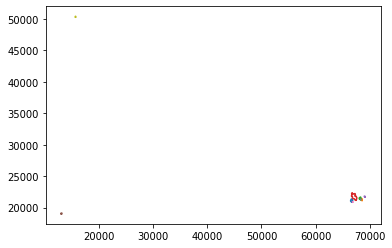

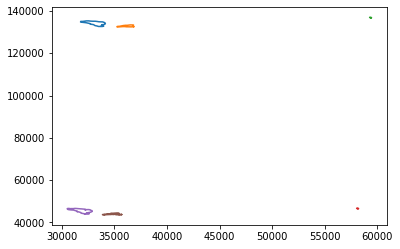

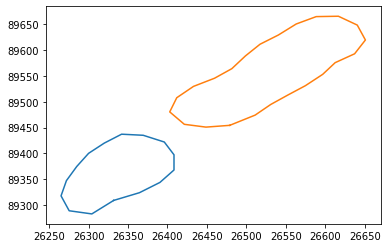

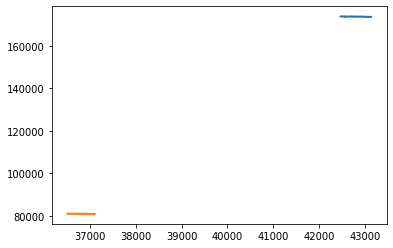

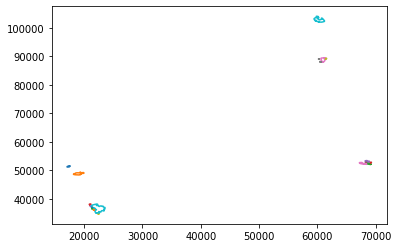

In [ ]:
Mask_and_Tile()

In [ ]:
!cp -r /content/masks/ /content/drive2/MyDrive/fyp/

In [ ]:
!cp -r /content/Tiles/ /content/drive2/MyDrive/fyp

In [ ]:
#to get number of masks and number of patches for fyp data tracking excel
#ls -1 /content/masks/*/*/ | wc -l

36


In [ ]:
!du -h /content/drive2/MyDrive/fyp/Tiles/

1.9G	/content/drive2/MyDrive/fyp/Tiles/patient_073/node_1
1.9G	/content/drive2/MyDrive/fyp/Tiles/patient_073
1.1G	/content/drive2/MyDrive/fyp/Tiles/patient_009/node_1
1.1G	/content/drive2/MyDrive/fyp/Tiles/patient_009
4.0K	/content/drive2/MyDrive/fyp/Tiles/.ipynb_checkpoints
2.7G	/content/drive2/MyDrive/fyp/Tiles/patient_052/node_1
2.7G	/content/drive2/MyDrive/fyp/Tiles/patient_052
1.5G	/content/drive2/MyDrive/fyp/Tiles/patient_022/node_4
1.5G	/content/drive2/MyDrive/fyp/Tiles/patient_022
2.2G	/content/drive2/MyDrive/fyp/Tiles/patient_039/node_1
2.2G	/content/drive2/MyDrive/fyp/Tiles/patient_039
1.7G	/content/drive2/MyDrive/fyp/Tiles/patient_060/node_3
1.7G	/content/drive2/MyDrive/fyp/Tiles/patient_060
1.1G	/content/drive2/MyDrive/fyp/Tiles/patient_004/node_4
1.1G	/content/drive2/MyDrive/fyp/Tiles/patient_004
1.1G	/content/drive2/MyDrive/fyp/Tiles/patient_072/node_0
1.1G	/content/drive2/MyDrive/fyp/Tiles/patient_072
373M	/content/drive2/MyDrive/fyp/Tiles/patient_017/node_1
373M	/conten

#EXTRA


---

Following code does not need to be run

#---

In [ ]:
patient_id = 'patient_004'
node_id = 'node_4'

In [ ]:
#!rm /content/training_data -r
!mkdir training_data

zip_path='training'
path_training_data=os.path.join(drive_wsi_path, zip_path,"*","*.zip")
print(path_training_data)
#patient_id = 'patient_009'
#node_id = 'node_1'

#Extract Patient Data from Camelyon zip to .tif folders
Extract_Data(path_training_data, '/content/training_data/', patient_id, node_id)



/content/drive2/MyDrive/CAMELYON17/training/*/*.zip

Extracting  /content/drive2/MyDrive/CAMELYON17/training/center_0/patient_004.zip
Inflating: 
patient_004_node_4.tif


In [ ]:
!python CLAM/create_patches.py --source training_data/*/ --save_dir RESULTS_DIRECTORY --patch_size 512 --step_size 512 --patch_level 1 --seg --patch --stitch 

In [ ]:
patches = getPatchCoords("/content/RESULTS_DIRECTORY/patches/" + patient_id
                          + '_' + node_id + '.h5')#patient_009_node_1.h5")

In [ ]:
src_annotation = '/content/training_annotations/' + patient_id + '_' + node_id + '.xml' #patient_009_node_1.xml'
WriteMasks(createMasksforNode(patches,src_annotation, 1), src_annotation)

In [ ]:
TileAllWSI('/content/RESULTS_DIRECTORY/patches/', '/content/Tiles/')

#Visualize Annotations

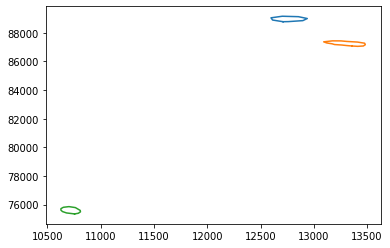

In [ ]:
polygon_points, mx, my = read_annotations('/content/training_annotations/' + patient_id
                          + '_' + node_id + '.xml')#patient_009_node_1.xml')

fig, ax = plt.subplots()

for poly in polygon_points:
  x, y = Polygon(poly).exterior.xy
  ax.plot(x,y)



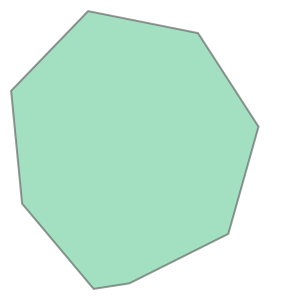

In [ ]:
Polygon(polygon_points[0])

#Visualize Data

In [ ]:
slide=openslide.OpenSlide('/content/training_data/' + patient_id + '/' + patient_id
                          + '_' + node_id + '.tif')# patient_009/patient_009_node_1.tif')
print(slide.level_dimensions)
slide.get_thumbnail((1000,1000))

OpenSlideUnsupportedFormatError: ignored

In [ ]:
slide.level_downsamples[1]

2.000010346611485

In [ ]:
#slide.read_region(( 48265, 138173),1,(512,512))

In [ ]:
#!git clone https://github.com/CODAIT/deep-histopath.git

In [ ]:
list(slide.properties.items())

[('openslide.level-count', '9'),
 ('openslide.level[0].downsample', '1'),
 ('openslide.level[0].height', '197226'),
 ('openslide.level[0].tile-height', '512'),
 ('openslide.level[0].tile-width', '512'),
 ('openslide.level[0].width', '96651'),
 ('openslide.level[1].downsample', '2.0000103466114849'),
 ('openslide.level[1].height', '98613'),
 ('openslide.level[1].tile-height', '512'),
 ('openslide.level[1].tile-width', '512'),
 ('openslide.level[1].width', '48325'),
 ('openslide.level[2].downsample', '4.0000823624608852'),
 ('openslide.level[2].height', '49306'),
 ('openslide.level[2].tile-height', '512'),
 ('openslide.level[2].tile-width', '512'),
 ('openslide.level[2].width', '24162'),
 ('openslide.level[3].downsample', '8.0001647249217704'),
 ('openslide.level[3].height', '24653'),
 ('openslide.level[3].tile-height', '512'),
 ('openslide.level[3].tile-width', '512'),
 ('openslide.level[3].width', '12081'),
 ('openslide.level[4].downsample', '16.001316242627169'),
 ('openslide.level[4]

<KeysViewHDF5 ['coords', 'imgs']>
[26578 56450]


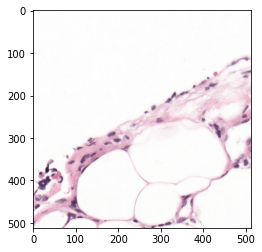

In [ ]:
import h5py
import matplotlib.pyplot as plt
with h5py.File('/content/RESULTS_DIRECTORY/patches/' + patient_id 
               + '_' + node_id + '.h5', 'r') as f:   #patient_009_node_1.h5', 'r') as f:
    print(f.keys())
    keys=list(f.keys())

    # sample
    print(f[keys[0]][0])
    plt.imshow(f[keys[1]][0])

#ZIPPING

In [ ]:
!zip -r "/content/Tiles.zip" "/content/Tiles/"

  adding: content/Tiles/ (stored 0%)
  adding: content/Tiles/.zip (stored 0%)
  adding: content/Tiles/patient_009/ (stored 0%)
  adding: content/Tiles/patient_009/node_1/ (stored 0%)
  adding: content/Tiles/patient_009/node_1/p_14882_62468.png (deflated 0%)
  adding: content/Tiles/patient_009/node_1/p_31477_80292.png (deflated 0%)
  adding: content/Tiles/patient_009/node_1/p_12834_64004.png (deflated 0%)
  adding: content/Tiles/patient_009/node_1/p_13346_64516.png (deflated 0%)
  adding: content/Tiles/patient_009/node_1/p_16418_58884.png (deflated 0%)
  adding: content/Tiles/patient_009/node_1/p_21026_89092.png (deflated 0%)
  adding: content/Tiles/patient_009/node_1/p_21026_90116.png (deflated 0%)
  adding: content/Tiles/patient_009/node_1/p_21026_82948.png (deflated 0%)
  adding: content/Tiles/patient_009/node_1/p_16930_66564.png (deflated 0%)
  adding: content/Tiles/patient_009/node_1/p_39081_70805.png (deflated 0%)
  adding: content/Tiles/patient_009/node_1/p_26869_57764.png (defla

In [ ]:
!zip -r "/content/RESULTS_DIRECTORY.zip" "/content/RESULTS_DIRECTORY/"

  adding: content/RESULTS_DIRECTORY/ (stored 0%)
  adding: content/RESULTS_DIRECTORY/process_list_autogen.csv (deflated 33%)
  adding: content/RESULTS_DIRECTORY/masks/ (stored 0%)
  adding: content/RESULTS_DIRECTORY/masks/patient_009_node_1.png (deflated 1%)
  adding: content/RESULTS_DIRECTORY/patches/ (stored 0%)
  adding: content/RESULTS_DIRECTORY/patches/patient_009_node_1.h5 (deflated 21%)
  adding: content/RESULTS_DIRECTORY/stitches/ (stored 0%)
  adding: content/RESULTS_DIRECTORY/stitches/patient_009_node_1.png (deflated 1%)


In [ ]:
!zip -r "/content/masks.zip" "/content/masks/"

#Copying to DRIVE

In [ ]:
#!cp /content/RESULTS_DIRECTORY.zip /content/drive2/MyDrive/fyp-preprocessing/

In [ ]:
#!cp /content/Tiles.zip /content/drive2/MyDrive/fyp-preprocessing/

In [ ]:
#!cp /content/maskpolygons.zip /content/drive2/MyDrive/fyp-preprocessing/

#Preprocessing/Testing - Above Combined

In [ ]:
#!rm /content/training_data -r

In [ ]:
"""!mkdir training_data

zip_path='training'
path_training_data=os.path.join(drive_wsi_path, zip_path,"*","*.zip")
print(path_training_data)
patient_id = 'patient_009'
node_id = 'node_1'

#Extract Patient Data from Camelyon zip to .tif folders
Extract_Data(path_training_data, '/content/training_data/', patient_id, node_id)"""

/content/drive2/MyDrive/CAMELYON17/training/*/*.zip

Extracting  /content/drive2/MyDrive/CAMELYON17/training/center_0/patient_009.zip
Inflating: 
patient_009_node_1.tif


In [ ]:
#!rm /content/RESULTS_DIRECTORY/ -r

rm: cannot remove '/content/RESULTS_DIRECTORY/': No such file or directory


In [ ]:
#!python CLAM/create_patches.py --source training_data/*/ --save_dir RESULTS_DIRECTORY --patch_size 512 --step_size 512 --patch_level 1 --seg --patch --stitch 

source:  training_data/patient_009/
patch_save_dir:  RESULTS_DIRECTORY/patches
mask_save_dir:  RESULTS_DIRECTORY/masks
stitch_save_dir:  RESULTS_DIRECTORY/stitches
source : training_data/patient_009/
save_dir : RESULTS_DIRECTORY
patch_save_dir : RESULTS_DIRECTORY/patches
mask_save_dir : RESULTS_DIRECTORY/masks
stitch_save_dir : RESULTS_DIRECTORY/stitches
{'seg_params': {'seg_level': -1, 'sthresh': 8, 'mthresh': 7, 'close': 4, 'use_otsu': False, 'keep_ids': 'none', 'exclude_ids': 'none'}, 'filter_params': {'a_t': 100, 'a_h': 16, 'max_n_holes': 8}, 'patch_params': {'white_thresh': 5, 'black_thresh': 40, 'use_padding': True, 'contour_fn': 'four_pt'}, 'vis_params': {'vis_level': -1, 'line_thickness': 250}}


progress: 0.00, 0/1
processing patient_009_node_1.tif
Creating patches for:  patient_009_node_1 ...
Bounding Box: 76115 126251 6818 18115
Contour Area: 38593377.0
patches extracted: 53
Bounding Box: 5537 113162 8259 27299
Contour Area: 53707568.0
patches extracted: 86
Bounding Box: 414

In [ ]:
#patches = getPatchCoords("/content/RESULTS_DIRECTORY/patches/patient_009_node_1.h5")

<KeysViewHDF5 ['coords', 'imgs']>
Keyed ( 2051 ) patches


In [ ]:
#slide.read_region(tuple([24821*2,72100*2]),1,(512,512))

PIL.Image.Image

In [ ]:
#!mkdir /content/training_annotations
#!unzip '/content/drive2/MyDrive/CAMELYON17/training/lesion_annotations.zip' -d /content/training_annotations

mkdir: cannot create directory ‘/content/training_annotations’: File exists
Archive:  /content/drive2/MyDrive/CAMELYON17/training/lesion_annotations.zip
replace /content/training_annotations/patient_004_node_4.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/training_annotations/patient_004_node_4.xml  
  inflating: /content/training_annotations/patient_009_node_1.xml  
  inflating: /content/training_annotations/patient_010_node_4.xml  
  inflating: /content/training_annotations/patient_012_node_0.xml  
  inflating: /content/training_annotations/patient_015_node_1.xml  
  inflating: /content/training_annotations/patient_015_node_2.xml  
  inflating: /content/training_annotations/patient_016_node_1.xml  
  inflating: /content/training_annotations/patient_017_node_1.xml  
  inflating: /content/training_annotations/patient_017_node_2.xml  
  inflating: /content/training_annotations/patient_017_node_4.xml  
  inflating: /content/training_annotations/patient_020_node_2.xml

In [ ]:
#!rm /content/maskspolygons -r

In [ ]:
#src_annotation = '/content/training_annotations/patient_009_node_1.xml'
#WriteMasks(createMasksforNode(patches,src_annotation, 1))

Max X - min X to get reduced dimensions: 5340.097600000001
Processing patch:  0
Patch Hit:  [23797 69028]
Patch Hit:  [24309 69028]
Patch Hit:  [23797 69540]
Patch Hit:  [24821 70564]
Patch Hit:  [24821 71076]
Patch Hit:  [25333 71076]
Patch Hit:  [24821 71588]
Patch Hit:  [25333 71588]
Patch Hit:  [25845 71588]
Patch Hit:  [26357 71588]
Patch Hit:  [24821 72100]
Patch Hit:  [25333 72100]
Patch Hit:  [25845 72100]
Patch Hit:  [26357 72100]
Patch Hit:  [24821 72612]
Patch Hit:  [25333 72612]
Patch Hit:  [25845 72612]
Patch Hit:  [26357 72612]
Processing patch:  1000
Processing patch:  2000
Number of Patch - Annotation hits: 32
Number of Patch hits: 18


100%|██████████| 18/18 [00:00<00:00, 36.09it/s]


#Consolidating Positive Masks and Patches for Comparison

In [ ]:
!rm -r "/content/testcompare_patches"
!mkdir "/content/testcompare_patches"

In [ ]:
masks_poly = glob.glob("/content/masks/*/*/*")
for m in masks_poly:
  
  shutil.copy(m, "/content/testcompare_patches/")
  patch_coords = str(m).split('/')[-1][:-4].split('_')[1:3]
  shutil.copy("/content/Tiles/" + patient_id + "/" + node_id + "/" + "p_"+patch_coords[0]+"_"+patch_coords[1]+".png",
              "/content/testcompare_patches/")

In [ ]:
!zip -r "/content/testcompare.zip" "/content/testcompare_patches"

updating: content/testcompare_patches/ (stored 0%)
  adding: content/testcompare_patches/mp_5280_37537.png (deflated 48%)
  adding: content/testcompare_patches/mp_6304_44193.png (deflated 39%)
  adding: content/testcompare_patches/p_6304_43681.png (deflated 0%)
  adding: content/testcompare_patches/p_6304_43169.png (deflated 0%)
  adding: content/testcompare_patches/p_5792_44193.png (deflated 0%)
  adding: content/testcompare_patches/mp_6304_43169.png (deflated 42%)
  adding: content/testcompare_patches/p_5280_37537.png (deflated 0%)
  adding: content/testcompare_patches/mp_5792_44193.png (deflated 88%)
  adding: content/testcompare_patches/mp_6304_43681.png (deflated 72%)
  adding: content/testcompare_patches/p_6304_44193.png (deflated 0%)


In [ ]:
!cp /content/testcompare.zip /content/drive2/MyDrive/fyp-preprocessing/

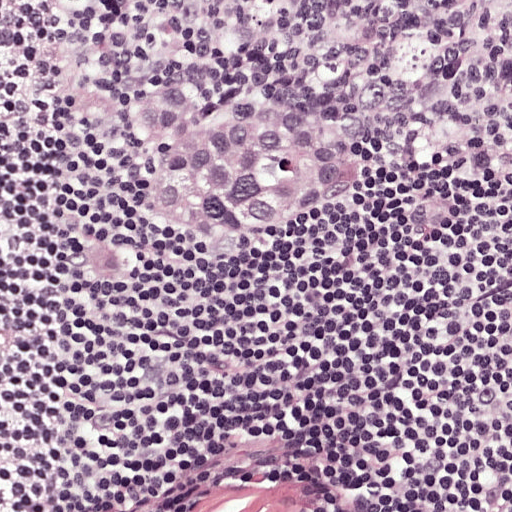

In [ ]:
cv2_imshow(cv2.imread("/content/Tiles/patient_009/node_1/p_25845_72612.png"))